In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from scipy.stats import multivariate_normal

In [2]:
data = pd.read_csv('data/particle_task/finger_annotations.csv')

In [3]:
def convert_coordinates(x, y, orig_res=(720,1280), new_res=(720,1280)):
    orig_width, orig_height = orig_res
    new_width, new_height = new_res

    # Compute scaling factors for x and y dimensions.
    scale_x = new_width / orig_width
    scale_y = new_height / orig_height

    # Convert the coordinates to the new scale.
    x_new = x * scale_x
    y_new = y * scale_y

    return int(x_new), int(y_new)

def annotate_video(video_path, estimated_coordinates, true_coordinates, output_video_path='particle_filter_annotated_video.mp4', estimate_color=(255, 0, 0), true_color=(255, 0, 0)):
  
    # Open the video file using OpenCV
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Unable to open video file.")
        return
    
    # Retrieve video properties for output video writing
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # End of video
        
        est_x = int(estimated_coordinates[idx, 0])  
        est_y = int(estimated_coordinates[idx, 1])
        est_x, est_y = convert_coordinates(est_x, est_y)
        
        # Draw a circle as a marker
        cv2.circle(frame, (est_x, est_y), radius=10, color=estimate_color, thickness=-1)

        try:
            true_x = int(true_coordinates[idx, 0])  
            true_y = int(true_coordinates[idx, 1])
            true_x, true_y = convert_coordinates(true_x, true_y)
            cv2.circle(frame, (true_x, true_y), radius=10, color=true_color, thickness=-1)
        except:
            pass
        
        idx += 1
        
        # Write the annotated frame to the output video
        out.write(frame)

        # Optionally, display the frame in a window
        cv2.imshow("Annotated Video", frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"Annotated video saved as {output_video_path}")

In [4]:
class ParticleFilter:
    '''
        defining a class to denote the particle filter model.
    '''

    def __init__(self, num_particles, particle_init_state, Q, R, dt = 1.0):

        self.num_particles = num_particles

        # Each particle is a state vector: [x, y, vx, vy] and with equal weights.
        self.particles = np.tile(particle_init_state, (num_particles, 1))
        self.particle_weights = np.ones(num_particles) / num_particles

        self.dt = dt

        # Transition matrix
        self.A = np.array([[1, 0, self.dt, 0],
                           [0, 1, 0, self.dt],
                           [0, 0, 1,  0],
                           [0, 0, 0,  1]])
        
        # Noise characteristic Covariance matrix
        self.Q = Q
        # Measurement Covariance matrix
        self.R = R

    def predict(self):
        # sample random noise for the process
        process_noise = np.random.multivariate_normal(np.zeros(4), self.Q, self.num_particles)

        # prediction
        self.particles = (self.A @ self.particles.T).T + process_noise
    
    def update(self, observations):

        # take the positions of particles after prediction
        predicted_positions = self.particles[:, 0:2]

        #Likelihood
        likelihood_distribution = multivariate_normal(mean=observations, cov=self.R)
        particle_likelihoods = likelihood_distribution.pdf(predicted_positions)

        # update particle weights
        self.particle_weights = self.particle_weights*particle_likelihoods

        # normalizing particle weights
        total_weight = np.sum(self.particle_weights)
        if total_weight == 0:
            self.particle_weights = np.ones(self.num_particles) / self.num_particles
        else:
            self.particle_weights /= total_weight
        return
    
    def resample(self):
        
        indices = np.random.choice(range(len(self.particle_weights)), self.num_particles, p=self.particle_weights)
        self.particles = self.particles[indices]
        self.particle_weights = self.particle_weights[indices]
    
        return

    def estimate_position(self):
        return np.average(self.particles[:, 0:2], weights=self.particle_weights, axis=0)
    

In [ ]:
# Load fingertip tracking data.
index_x = data['Index_X'].values
index_y = data['Index_Y'].values
little_x = data['Little_X'].values
little_y = data['Little_Y'].values

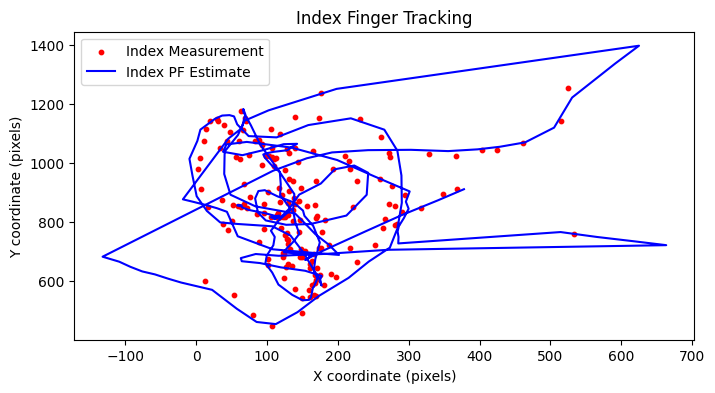

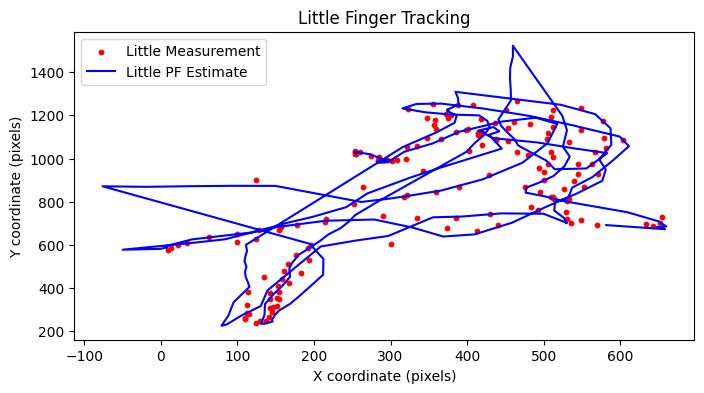

In [6]:
# Define parameters.
num_particles = 1000
dt = 1.0

state_noise_std = 50.0
Q = np.diag([state_noise_std**2, state_noise_std**2, (state_noise_std/2)**2, (state_noise_std/2)**2])

meas_noise_std = 100.0
R = np.diag([meas_noise_std**2, meas_noise_std**2])

# Initialize particle filters.
init_index = [index_x[0], index_y[0], 0, 0]
init_little = [little_x[0], little_y[0], 0, 0]

pf_index = ParticleFilter(num_particles, init_index, Q, R, dt)
pf_little = ParticleFilter(num_particles, init_little, Q, R, dt)

# Collect state estimates.
estimates_index = []
estimates_little = []

# Main filtering loop.
for ix, iy, lx, ly in zip(index_x, index_y, little_x, little_y):
    pf_index.predict()
    if not (np.isnan(ix) or np.isnan(iy)):
        measurement_index = np.array([ix, iy])
        pf_index.update(measurement_index)
        pf_index.resample()
    estimates_index.append(pf_index.estimate_position())

    pf_little.predict()
    if not (np.isnan(lx) or np.isnan(ly)):
        measurement_little = np.array([lx, ly])
        pf_little.update(measurement_little)
        pf_little.resample()
    estimates_little.append(pf_little.estimate_position())

# Convert estimates to arrays.
estimates_index = np.array(estimates_index)
estimates_little = np.array(estimates_little)

# Plotting the tracking results.
plt.figure(figsize=(8, 4))
plt.scatter(index_x, index_y, c='red', s=10, label='Index Measurement')
plt.plot(estimates_index[:, 0], estimates_index[:, 1], c='blue', label='Index PF Estimate')
plt.title('Index Finger Tracking')
plt.legend()
plt.xlabel('X coordinate (pixels)')
plt.ylabel('Y coordinate (pixels)')

plt.figure(figsize=(8, 4))
plt.scatter(little_x, little_y, c='red', s=10, label='Little Measurement')
plt.plot(estimates_little[:, 0], estimates_little[:, 1], c='blue', label='Little PF Estimate')
plt.title('Little Finger Tracking')
plt.legend()
plt.xlabel('X coordinate (pixels)')
plt.ylabel('Y coordinate (pixels)')

plt.show()

In [ ]:
annotate_video('data/particle_task/3D_hand_tracking.mp4', estimates_index, np.concat((index_x.reshape(-1, 1), index_y.reshape(-1, 1)), axis=1)
               ,output_video_path='generated_videos/particle_filter_index_annotation.mp4', estimate_color=(255, 0, 0), true_color=(0, 0, 255))

Annotated video saved as particle_filter_index_annotation.mp4


In [ ]:
annotate_video('data/particle_task/3D_hand_tracking.mp4', estimates_little, np.concat((little_x.reshape(-1, 1), little_y.reshape(-1, 1)), axis=1)
               ,output_video_path='generated_videos/particle_filter_little_annotation.mp4', estimate_color=(255, 0, 0), true_color=(0, 0, 255))

Annotated video saved as particle_filter_little_annotation.mp4


In [ ]:
annotate_video('generated_videos/particle_filter_index_annotation.mp4', estimates_little, np.concat((little_x.reshape(-1, 1), little_y.reshape(-1, 1)), axis=1)
               ,output_video_path='generated_videos/particle_filter_combined_annotation.mp4', estimate_color=(255, 0, 0), true_color=(0, 0, 255))

Annotated video saved as particle_filter_combined_annotation.mp4
